In [1]:
import numpy as np
import cv2
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

###########################################################

from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.applications import VGG16, ResNet50
import keras.backend as K

###########################################################

from ssd.generator import Generator
from ssd.data_augmenter import DataAugmenter
from ssd.bbox_codec import BBoxCodec, LargestObjClassCodec, LargestObjBoxCodec, LargestObjBoxAndClassCodec
from ssd.losses import SsdLoss

import ssd.prior_box as pb
import ssd.imaging as imaging
import ssd.tools as tools
import ssd.data as data

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
################################################################################
voc_2012_base_dir = '../datasets/voc/VOCtrainval_11-May-2012/'
voc_2007_base_dir = '../datasets/voc/VOCtrainval_06-Nov-2007/'

use_voc_2012 = False#True

if use_voc_2012:
    voc_base_dir = voc_2012_base_dir 
    gtb_file = 'data/pascal_voc_2012.p'
else:
    voc_base_dir = voc_2007_base_dir 
    gtb_file = 'data/pascal_voc_2007.p'

img_dir = voc_base_dir + 'JPEGImages/'

target_img_size = (300, 300)
input_dim = (300, 300, 3)
num_classes = 21
hard_neg_pos_ratio = 3
encode_variances = True#False
match_per_prediction = True#False
use_bn=False#True
use_dropout=False#True
batch_size=16
nb_epoch = 100#50
early_stopping_patience=5

################################################################################

# Load prepared GroundTruth boxes
gtb = pickle.load(open(gtb_file, 'rb'))

#img_file_names = shuffle(list(gtb.keys()))
#train_samples, valid_samples = train_test_split(img_file_names, test_size=0.1)

#train_samples =  data.load_samples_list(voc_base_dir + 'ImageSets/Main/train.txt')
#valid_samples =  data.load_samples_list(voc_base_dir + 'ImageSets/Main/val.txt')
train_val_samples = data.load_samples_list(voc_base_dir + 'ImageSets/Main/trainval.txt')
train_val_samples = shuffle(train_val_samples)
train_samples, valid_samples = train_test_split(train_val_samples, test_size=0.2)

# Degug using fitting tiny dataset
#img_file_names = list(gtb.keys())[:16] 
#train_samples, valid_samples = img_file_names[:14], img_file_names[14:]
#train_samples, valid_samples = [img_file_names[1]],[img_file_names[0]]

print('Train size: {0}'.format(len(train_samples)))
print('Valid size: {0}'.format(len(valid_samples)))

# calc # of samples per epoch
nb_samples_per_epoch = len(train_samples)
nb_valid_samples = len(valid_samples)

nb_steps_per_epoch = max(int(nb_samples_per_epoch/batch_size), 1)
nb_valid_steps_per_epoch = max(int(nb_valid_samples/batch_size), 1)

print('nb_steps_per_epoch: {0}'.format(nb_steps_per_epoch))
print('nb_valid_steps_per_epoch: {0}'.format(nb_valid_steps_per_epoch))

################################################################################

bbox_codec = LargestObjClassCodec()
#bbox_codec = LargestObjBoxCodec()
#bbox_codec = LargestObjBoxAndClassCodec()
augmenter = DataAugmenter()
gen = Generator(gtb, img_dir, target_img_size, augmenter, bbox_codec, do_augment=True)
#gen = OneBoxGenerator(gtb, img_dir, target_img_size)
# compile and train the model using the generator function
train_generator = gen.flow(train_samples, batch_size=batch_size)
valid_generator = gen.flow(valid_samples, batch_size=batch_size)


################################################################################

Train size: 4008
Valid size: 1003
nb_steps_per_epoch: 250
nb_valid_steps_per_epoch: 62


In [3]:
img_2012_dir = voc_2012_base_dir + 'JPEGImages/'

test_files = ['2007_000032.jpg', '2007_000256.jpg', '2007_000464.jpg', '2007_002462.jpg',
               '2007_002953.jpg', '2007_001149.jpg', '2007_001558.jpg', '2007_002088.jpg', '2007_003143.jpg']

# ResNet50

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1365      
Total params: 23,720,213
Trainable params: 4,598,165
Non-trainable params: 19,122,048
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 151s - loss: 1.9648 - acc: 0.4471 - val_loss: 3.1650 - val_acc: 0.02

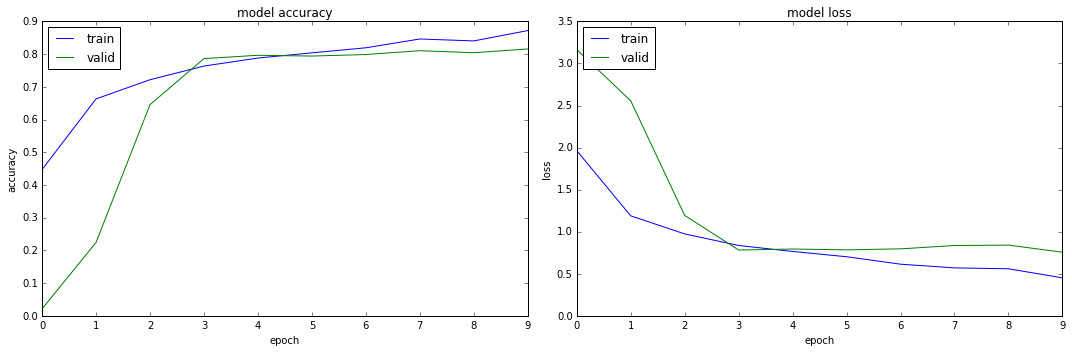

In [4]:
#K.clear_session()

base_net_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=input_dim)
# Freeze all layers except starting from  res5c_branch2a
base_net_model1.trainable = True
trainable = False
for layer in base_net_model1.layers:
    if layer.name == 'res5c_branch2a':
        trainable = True
    layer.trainable = trainable
    
model1 = models.Sequential()
model1.add(base_net_model1)
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(num_classes, activation='softmax'))

#base_net_model1.summary()
model1.summary()

# 1e-4 give a bit better result than 1e-3
model1.compile(optimizer=optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])

history1 = model1.fit_generator(train_generator, steps_per_epoch=nb_steps_per_epoch,
                              validation_data=valid_generator, validation_steps=nb_valid_steps_per_epoch,
                              #callbacks=[checkpoint],
                              epochs=10#nb_epoch,
                              )
model1.save_weights('models/one-class-resnet50-voc-2007.h5')

tools.plot_history_curve_loss_and_acc(history1)

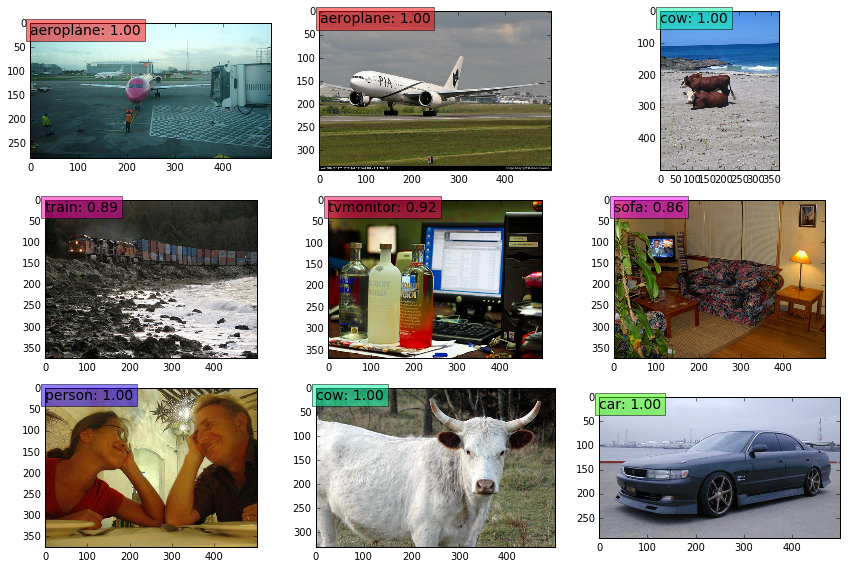

In [7]:
test_images, x_test, y_pred = tools.make_prediction(model1, target_img_size, img_2012_dir, test_files)
tools.show_classes(test_images, y_pred, num_classes, 3)

# VGG16

In [ ]:
base_net_model2 = VGG16(weights='imagenet', include_top=False, input_shape=input_dim)
base_net_model2.trainable = True
trainable = False
for layer in base_net_model2.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable
    
model2 = models.Sequential()
model2.add(base_net_model2)
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))

#base_net_model2.summary()
model2.summary()

# Adam with 1e-3 stucks and the model can't learn at all
model2.compile(optimizer=optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])

history2 = model2.fit_generator(train_generator, steps_per_epoch=nb_steps_per_epoch,
                              validation_data=valid_generator, validation_steps=nb_valid_steps_per_epoch,
                              #callbacks=[checkpoint],
                              epochs=10#nb_epoch,
                              )

model2.save_weights('models/one-class-vgg16-voc-2007.h5')


tools.plot_history_curve_loss_and_acc(history2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2654272   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 21)                1365      
Total params: 17,370,325
Trainable params: 9,735,061
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 178s - loss: 2.4861 - acc: 0.2537 - val_loss: 2.1029 - val_acc: 0.401

In [ ]:
test_images2, x_test2, y_pred2 = tools.make_prediction(model2, target_img_size, img_2012_dir, test_files)
tools.show_classes(test_images2, y_pred2, num_classes, 3)